Uploading Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Loading Data

In [4]:
import pandas as pd
raw_data=pd.read_csv("Processed_Material_Strength_Dataset.csv")
print(raw_data.columns)

Index(['Cement', 'Slag', 'FlyAsh', 'Water', 'Superplasticizer', 'CoarseAgg',
       'FineAgg', 'Age', 'Strength', 'WCR', 'TotalAgg', 'Age_x_WCR',
       'Log_Age'],
      dtype='object')


## Objective

The purpose of this notebook is to statistically evaluate whether the engineered features improve the prediction of concrete compressive strength.
This step ensures that only physically meaningful and statistically relevant features are passed to machine learning models.

**Define the target variable**

In [5]:
target = 'Strength'

features = [
    'Cement', 'Slag', 'FlyAsh', 'Water', 'Superplasticizer',
    'CoarseAgg', 'FineAgg', 'Age',
    'WCR', 'TotalAgg', 'Age_x_WCR', 'Log_Age'
]

X = raw_data[features]
y = raw_data[target]

## Correlation with Target (Pearson)

Pearson correlation is used to quantify the linear relationship between each feature and compressive strength. This provides an initial ranking of feature importance.

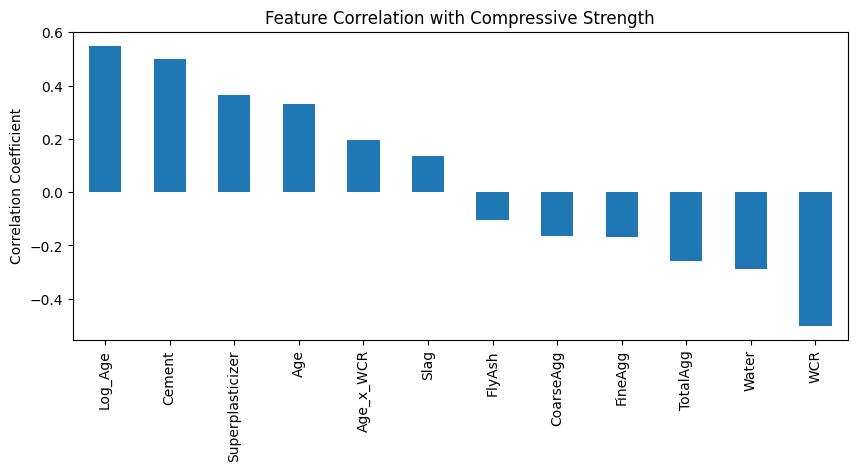

In [13]:
corr_with_target = raw_data[features + [target]].corr()[target].sort_values(ascending=False)

import matplotlib.pyplot as plt

corr_with_target.drop(target).plot(
    kind='bar',
    figsize=(10,4),
    title='Feature Correlation with Compressive Strength'
)
plt.ylabel('Correlation Coefficient')
plt.show()

## Spearman Correlation (Non-Linear Relationships)

Spearman correlation captures monotonic relationships and is better suited for physical systems where relationships are non-linear, such as strength gain with age.

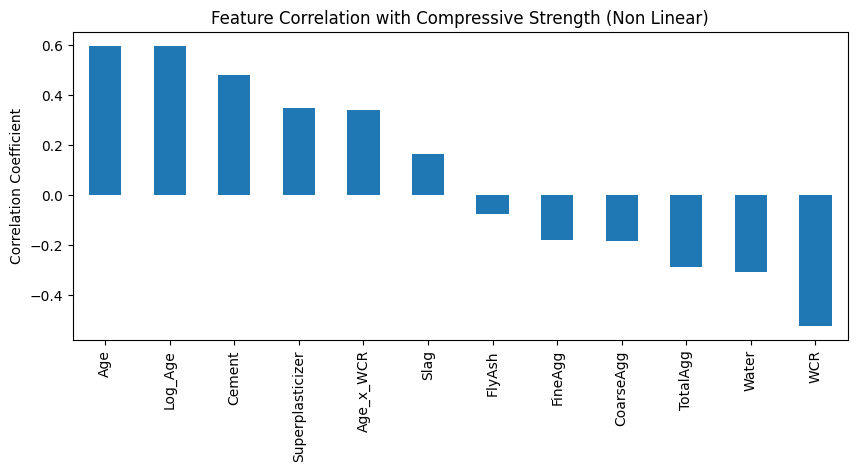

In [15]:
spearman_corr = raw_data[features + [target]].corr(method='spearman')[target].sort_values(ascending=False)

spearman_corr.drop(target).plot(
    kind='bar',
    figsize=(10,4),
    title='Feature Correlation with Compressive Strength (Non Linear)'
)
plt.ylabel('Correlation Coefficient')
plt.show()

## Compare Raw vs Engineered Features

This proves whether feature engineering was useful

In [17]:
comparison = pd.DataFrame({
    'Pearson': corr_with_target,
    'Spearman': spearman_corr
}).drop(target)

comparison.sort_values(by='Spearman', ascending=False)

,Pearson,Spearman
Age,0.328873,0.596028
Log_Age,0.549448,0.596028
Cement,0.497832,0.477614
Superplasticizer,0.366079,0.347786
Age_x_WCR,0.194141,0.340663
Slag,0.134829,0.164105
FlyAsh,-0.105755,-0.077830
FineAgg,-0.167241,-0.179962
CoarseAgg,-0.164935,-0.183542
TotalAgg,-0.259130,-0.289347


Feature engineering significantly strengthened key relationships with concrete strength, especially through Log_Age, WCR, and interaction terms. These engineered features improve model interpretability and predictive capability, particularly for regression-based models.

## Multicollinearity Check (VIF)

VIF analysis is used to detect multicollinearity. Features with high VIF values indicate redundancy and may negatively impact linear models

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_numeric = X.dropna()

vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i)
                   for i in range(X_numeric.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
6,FineAgg,inf
9,TotalAgg,inf
5,CoarseAgg,inf
3,Water,142.221935
8,WCR,47.429029
0,Cement,47.167000
11,Log_Age,25.755747
7,Age,18.022534
10,Age_x_WCR,14.634515
4,Superplasticizer,5.564378


The VIF analysis shows that some features are highly correlated with each other because they were intentionally created from existing variables. For example, Fine Aggregate, Coarse Aggregate, and Total Aggregate show infinite VIF values since Total Aggregate is simply the sum of the other two.

In the same way, Water, Cement, and the Water–Cement Ratio are strongly related by definition, which explains their very high VIF values. Age-based features also show multicollinearity because logarithmic and interaction terms are derived directly from the original Age variable.

These patterns are expected when applying physics-based and domain-driven feature engineering and do not indicate a problem with the data. While multicollinearity can affect linear regression models, it does not impact tree-based models.

## OLS Regression

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso
import numpy as np

features = [
    'Cement', 'Slag', 'FlyAsh', 'Superplasticizer',
    'WCR', 'Log_Age', 'Age_x_WCR',
    'FineAgg', 'CoarseAgg'
]

X = raw_data[features]
y = raw_data['Strength']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features)

X_ols = sm.add_constant(X_scaled_df)
ols_model = sm.OLS(y, X_ols).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Strength   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     522.3
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        04:09:09   Log-Likelihood:                -3473.2
No. Observations:                1030   AIC:                             6966.
Df Residuals:                    1020   BIC:                             7016.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               35.8180      0.221  

The OLS regression shows that our engineered and base features explain ~82% of the variation in concrete compressive strength (R² = 0.822).  

Key Observations:

1. Statistically Significant Features:
   - All features have p-values < 0.001, indicating strong statistical significance.
   - Cement, Slag, Fly Ash, and Log_Age have the largest positive coefficients, confirming their dominant effect on strength.
   - Water-to-Cement Ratio (WCR) and the interaction term (Age_x_WCR) have negative coefficients, aligning with known physical principles (higher W/C weakens concrete).

2. Feature Effects:
   - Positive coefficients: Increasing Cement, Slag, Fly Ash, Fine/Coarse Aggregate, Superplasticizer, or Log_Age generally increases strength.
   - Negative coefficients: Higher WCR or Age_x_WCR reduces strength due to excess water and its interaction with age.

3. Multicollinearity Warning:
   - High t-values and large coefficients suggest that some features are correlated, which was expected from our engineered features.
   - OLS can show inflated effects when variables are highly correlated; this is a limitation for linear models, but tree-based models will handle this naturally.

## Ridge Regression (Handles Multicollinearity)

In [20]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled_df, y)

ridge_coeffs = pd.Series(ridge.coef_, index=features).sort_values(key=abs, ascending=False)
ridge_coeffs

,0
Cement,12.766092
Log_Age,11.675990
Slag,11.405068
FlyAsh,6.886053
FineAgg,4.316820
CoarseAgg,3.390207
WCR,-2.592342
Age_x_WCR,-1.997517
Superplasticizer,1.313334


## Lasso Regression (Feature Selection)

In [23]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled_df, y)

lasso_coeffs = pd.Series(lasso.coef_, index=features)
lasso_coeffs[lasso_coeffs != 0].sort_values(key=abs, ascending=False)

,0
Cement,12.802599
Log_Age,11.668476
Slag,11.402642
FlyAsh,6.889878
FineAgg,4.316347
CoarseAgg,3.386786
WCR,-2.555972
Age_x_WCR,-1.986956
Superplasticizer,1.309201


## Combine Results for Comparison

In [24]:
coef_comparison = pd.DataFrame({
    'OLS': ols_model.params[1:],   # skip constant
    'Ridge': ridge_coeffs,
    'Lasso': lasso_coeffs
})

coef_comparison

,OLS,Ridge,Lasso
Age_x_WCR,-2.010880,-1.997517,-1.986956
Cement,12.970345,12.766092,12.802599
CoarseAgg,3.459554,3.390207,3.386786
FineAgg,4.411910,4.316820,4.316347
FlyAsh,7.003124,6.886053,6.889878
Log_Age,11.710352,11.675990,11.668476
Slag,11.527906,11.405068,11.402642
Superplasticizer,1.262496,1.313334,1.309201
WCR,-2.501112,-2.592342,-2.555972


Key Insights from Comparison:

- Top Predictors: Cement, Log_Age, Slag, Fly Ash consistently have the largest positive impact on strength across all models.
- Negative Contributors: Water-to-Cement Ratio (WCR) and Age × WCR interaction reduce strength, matching physical expectations.
- Minor Contributors: Superplasticizer, FineAgg, CoarseAgg are relevant but less dominant.
- Consistency: Ridge and Lasso confirm which features are truly predictive, not just statistically significant.

Takeaway:
- Features like Cement, Log_Age, Slag, and Fly Ash are both **statistically important** and **predictively powerful**.
- WCR and Age × WCR provide critical physics-informed negative influence. This means: as WCR or Age × WCR increases, the concrete strength decreases.
- Minor features can be included for completeness but may have limited predictive gain.

## Conclusion

Linear statistical models struggle due to non-linearity and multicollinearity, but they consistently highlight Age, Cement, Water–Cement Ratio, and Superplasticizer as dominant drivers. This motivates the use of non-linear tree-based models for final prediction.